In [1]:
import pandas as pd
import geopandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import random
from scipy import stats
from scipy import integrate
import glob
import seaborn as sns
# %matplotlib notebook
%matplotlib inline
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from fitter import Fitter, get_common_distributions, get_distributions

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Estimation of CAFOs sizes distribution for the states of:

- Ohio
- Pennsylvania
- Indiana
- Michigan
- Wisconsin

Import data files

# We filter the CAFOs, considering a range between 300 and 10,000 animal units

In [2]:
CAFOs_Ohio = pd.read_csv('USCafosData/Ohio_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)
CAFOs_Michigan = pd.read_csv('USCafosData/Michigan_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)
CAFOs_Wisconsin = pd.read_csv('USCafosData/Wisconsin_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)
CAFOs_Pennsylvania = pd.read_csv('USCafosData/Pennsylvania_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)
CAFOs_Indiana = pd.read_csv('USCafosData/Indiana_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)

CAFOs_Dict ={'Ohio':CAFOs_Ohio[(CAFOs_Ohio['Animal Units']> 300) & (CAFOs_Ohio['Animal Units']< 10000)]['Animal Units'],
             'Michigan':CAFOs_Michigan[(CAFOs_Michigan['Animal Units']> 300) & (CAFOs_Michigan['Animal Units']< 10000)]['Animal Units'],
             'Wisconsin':CAFOs_Wisconsin[(CAFOs_Wisconsin['Animal Units']> 300) & (CAFOs_Wisconsin['Animal Units']< 10000)]['Animal Units'],
             'Pennsylvania':CAFOs_Pennsylvania[(CAFOs_Pennsylvania['Animal Units']> 300) & (CAFOs_Pennsylvania['Animal Units']< 10000)]['Animal Units'],
             'Indiana':CAFOs_Indiana[(CAFOs_Indiana['Animal Units']> 300) & (CAFOs_Indiana['Animal Units']< 10000)]['Animal Units']}

CAFOs_Merged = pd.DataFrame(data = CAFOs_Dict)
CAFOs_Merged.describe().to_csv('CAFOsStatisticsSummary'+'.csv')
CAFOs_Merged

,Ohio,Michigan,Wisconsin,Pennsylvania,Indiana
0,4000.0,1500.0,1000.0,612.04,2000.0
1,2070.0,7601.0,2013.0,1509.75,1650.0
2,1085.0,2000.0,1214.0,1737.42,750.0
3,820.0,4500.0,1604.0,384.34,NaN
4,1200.0,4500.0,860.0,1070.86,575.0
5,3600.0,2900.0,2792.0,720.52,500.0
6,1072.0,950.0,1500.0,915.30,1200.0
7,3020.0,2375.0,1105.0,660.18,560.0
8,9800.0,500.0,2521.0,NaN,600.0
9,1838.0,1990.0,2531.0,619.30,557.0


In [3]:
CAFOs_Merged.describe()

,Ohio,Michigan,Wisconsin,Pennsylvania,Indiana
count,53.000000,144.000000,276.000000,130.000000,115.000000
mean,2415.245283,2461.527778,2393.431159,1398.357923,1529.521739
std,1588.246879,1333.813099,1457.032638,1076.216680,1541.598523
min,820.000000,420.000000,396.000000,328.400000,310.000000
25%,1500.000000,1347.500000,1499.000000,670.910000,500.000000
50%,2000.000000,2225.000000,1941.500000,1215.245000,760.000000
75%,2800.000000,3420.000000,2812.250000,1700.362500,1959.500000
max,9800.000000,7601.000000,9979.000000,7533.190000,7040.000000


In [4]:
def NumberOfBins(data_list): #computing the optimal number of bins using the Freedman-Diaconis rule
    # Computing IQR
    Q1 = data_list.quantile(0.25)
    Q3 = data_list.quantile(0.75)
    IQR = Q3 - Q1

    bins_width = 2*IQR/(data_list.count()**(1/3)) #Freedman-Diaconis rule

    bins_number = int(round((data_list.max()-data_list.min())/bins_width,0))
    return bins_number

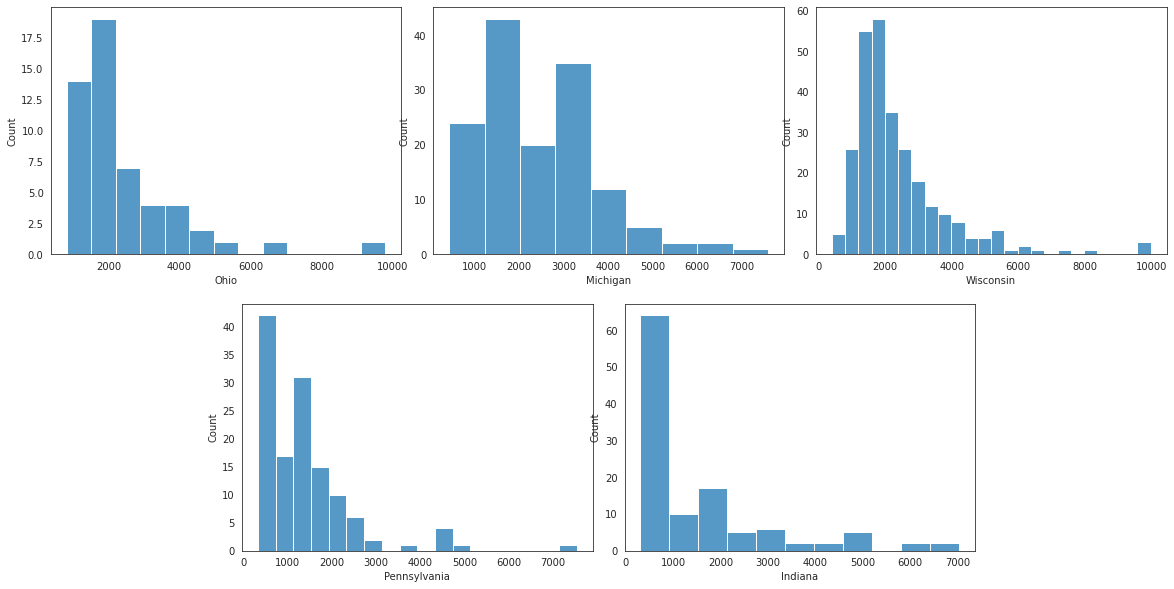

In [5]:
sns.set_style('white')

# fig, ax =plt.subplots(2,3,figsize=(20,10))

# ax_rows = np.arange(0,len(ax)) #This is because it is 2 dimensional array
# ax_columns = np.arange(0,len(ax[0])) #This is because it is 2 dimensional array

# ax_matrix = []#This is because it is 2 dimensional array
# for i in ax_rows:
#     for ii in ax_columns:
#         ax_element = [i,ii]
#         ax_matrix.append(ax_element) 
        
# sns.histplot(CAFOs_Merged[state].dropna(), ax=ax[ax_number[0]][ax_number[1]])


fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(2, 6)

count = 0
for state in CAFOs_Merged.columns:
    if count < 3: #This is for centering the last row of plots
        ax = plt.subplot(gs[0, 2 * count:2 * count + 2])
    else:
        ax = plt.subplot(gs[1, 2 * count - 5:2 * count + 2 - 5])
              
    sns.histplot(CAFOs_Merged[state].dropna(), ax=ax, bins=NumberOfBins(CAFOs_Merged[state].dropna()) )
    count = count+1

# fig.delaxes(ax[ax_matrix[-1][0],ax_matrix[-1][1]])

In [6]:
# # fitting_values = CAFOs_Ohio['Animal Units'].values

# # fit_variable = Fitter(fitting_values,
# #                distributions=[
# #                               'gamma',
# #                               'lognorm',
# #                               "beta",
# #                               "gennorm",
# #                               "t",
# #                               "norm",
# #                                "lognorm",
# #                                "dweibull"]
# #                                      )
# # fit_variable.fit()
# # fit_variable.summary()

# Fits_CAFOs_Summary = dict()
# for state in CAFOs_Merged:
#     fitting_values = CAFOs_Merged[state].dropna().values

#     fit_variable = Fitter(fitting_values,
#                    distributions=[
#                                   'gamma',
#                                   'lognorm',
#                                   "beta",
#                                   "gennorm",
#                                   "t",
#                                   "norm",
#                                    "lognorm",
#                                    "dweibull"]
#                                          )
#     fit_variable.fit()
#     print(state)
#     fit_variable.summary()
#     Fits_CAFOs_Summary[state] = fit_variable.summary()
#     fit_variable.summary().plot()

In [7]:
# Fits_CAFOs_Summary

In [8]:
# Fits_CAFOs_Summary = dict()
# for state in CAFOs_Merged:
#     fitting_values = CAFOs_Merged[state].dropna().values

#     fit_variable = Fitter(fitting_values,
#                    distributions=get_common_distributions()
#                                          )
#     fit_variable.fit()
#     print(state)
#     fit_variable.summary()
#     Fits_CAFOs_Summary[state] = fit_variable.summary()
#     fit_variable.summary().plot()

# After a visual analysis of the distributions we select the following ones:

## Generalized normal distributions for all cases, discarding Michigan that shows a not clear short of binomial dstribution

In [9]:
# Fits_CAFOs_Summary = dict()
# for state in CAFOs_Merged:
#     fitting_values = CAFOs_Merged[state].dropna().values
    
#     if CAFOs_Merged.describe().loc['count'][state] <100:

#         fit_variable = Fitter(fitting_values,
#                        distributions=['gennorm']
#                                              )
        
#     elif state == 'Indiana':
#         fit_variable = Fitter(fitting_values,
#                        distributions=['lognorm']
#                                              )
        
#     else:
#         fit_variable = Fitter(fitting_values,
#                        distributions=['gennorm']
#                                              )
    
    
#     fit_variable.fit()
#     print(state)
#     fit_variable.summary()
#     Fits_CAFOs_Summary[state] = fit_variable.summary()
#     fit_variable.summary().plot()
#     fit_variable.plot_pdf()

In [10]:
# # a = fit_variable.summary(plotsavename="a")  # s is an instance of Series
# # fig = ax[0][0].get_figure()
# fit_variable = Fitter(CAFOs_Merged['Ohio'].dropna().values,
#                        distributions=['gennorm']
#                                              )
# fit_variable.fit()
# fit_variable.fitted_param["gennorm"]

In [11]:
# dist = getattr(stats, 'gennorm')
# dist.fit(CAFOs_Merged['Ohio'].dropna().values)

# stat='count',

In [12]:
# beta1, loc1, scale1 = stats.gennorm.fit(CAFOs_Merged['Ohio'].dropna().values)

In [13]:
# beta1

In [14]:
# fig, ax = plt.subplots(1, 1)
# x = np.linspace(CAFOs_Merged['Ohio'].dropna().values.min(),CAFOs_Merged['Ohio'].dropna().values.max(),CAFOs_Merged['Ohio'].dropna().count())
# # ax = plt.plot(stats.gennorm.pdf(x, beta1, loc=loc1, scale=scale1))
# ax.plot(x, stats.gennorm.pdf(x, beta1, loc1, scale1),
#        'r-', lw=1, alpha=1, label='gennorm pdf')
# # ax.plot(x, stats.gennorm.pdf(np.linspace(stats.gennorm.ppf(0.01, 1.3),
# #                 stats.gennorm.ppf(0.99, 1.3), 100), 1.3),
#        # 'r-', lw=5, alpha=0.6, label='gennorm pdf')
# ax = plt.hist(CAFOs_Merged['Ohio'].dropna().values, bins=CAFOs_Merged['Ohio'].dropna().count(), density=True, histtype='stepfilled', alpha=1) #NumberOfBins(CAFOs_Merged['Ohio'].dropna())

# Since the size of CAFOs are limited between 300 and 10,000, we used a truncated normal distribution

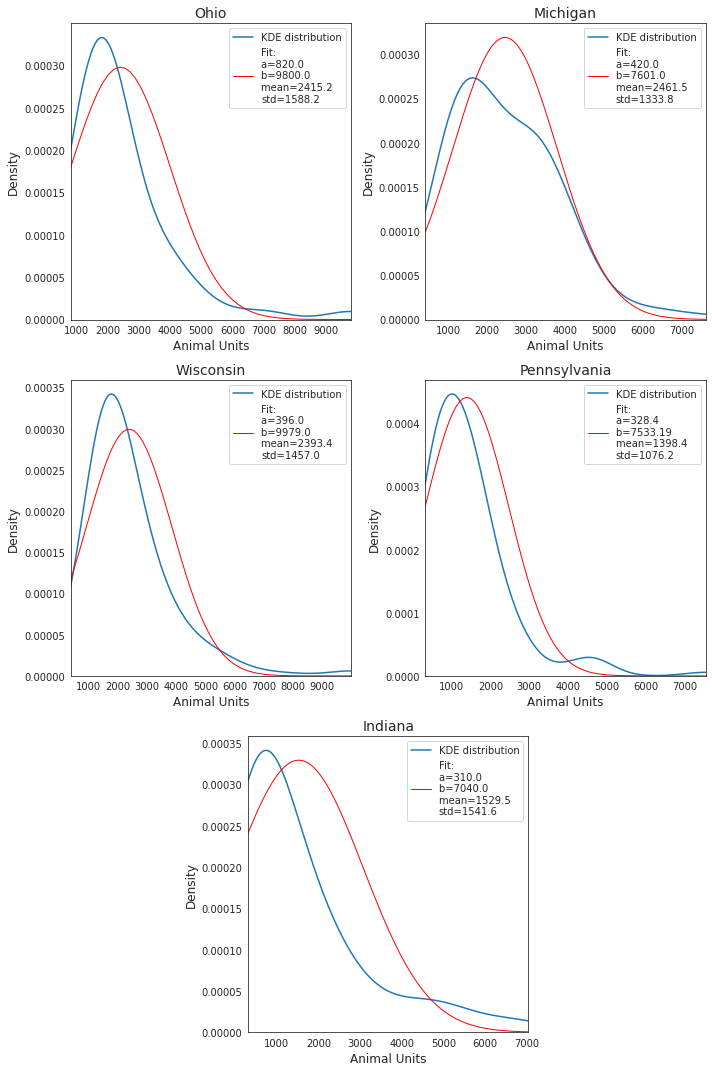

In [15]:
fig = plt.figure(figsize=(10,15))
gs = gridspec.GridSpec(3, 4)

param_df = pd.DataFrame(['mean','std','a','b'], columns=['Parameters']).set_index('Parameters')

count = 0
for state in CAFOs_Merged.columns:
    alpha1, beta1, loc1, scale1 = stats.truncnorm.fit(CAFOs_Merged[state].dropna().values)
    x = np.linspace(CAFOs_Merged[state].dropna().values.min(),CAFOs_Merged[state].dropna().values.max(),CAFOs_Merged[state].dropna().count())
    
    mean = CAFOs_Merged.describe().loc['mean'][state]
    std = CAFOs_Merged.describe().loc['std'][state]
    
    if count < 2: #This is for centering the last row of plots
        ax = plt.subplot(gs[0, 2*count:2*count+2])
    elif count < 4:
        ax = plt.subplot(gs[1, 2*(count-2):2*(count-2)+2])
    else:
        ax = plt.subplot(gs[2, 1:3])
              
    sns.kdeplot(CAFOs_Merged[state].dropna().values, bw_method=0.5, label='KDE distribution', ax=ax)
    ax.plot(x, stats.truncnorm.pdf(x,
                                (CAFOs_Merged[state].dropna().values.min()-mean)/std,
                                (CAFOs_Merged[state].dropna().values.max()-mean)/std,
                                loc =mean,
                                scale =std),'r-', lw=1, alpha=1,
                  label='Fit: \na={} \nb={} \nmean={} \nstd={}'.format(CAFOs_Merged[state].dropna().values.min(),
                                                                  CAFOs_Merged[state].dropna().values.max(),
                                                                 round(mean,1),round(std,1)))
    # ax.hist(CAFOs_Merged[state].dropna().values, density=True, histtype='stepfilled', alpha=1) #bins=CAFOs_Merged[state].dropna().count() NumberOfBins(CAFOs_Merged['Ohio'].dropna())
    ax.set_xlim(xmin = CAFOs_Merged[state].min(), xmax = CAFOs_Merged[state].max())
    ax.legend() #names_outflows, loc='upper center', ncol=1, prop={'size': 12}, bbox_to_anchor=(0.35, 0.36)
    ax.set_xlabel("Animal Units", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    # ax.set_xticks(np.linspace(CAFOs_Merged[state].min(),CAFOs_Merged[state].max(),5))
    # ax.tick_params(axis='both', which='major', labelsize=10)
    ax.xaxis.set_major_locator(MultipleLocator(1000))
    # plt.setp(ax.get_xticklabels(), visible=True, rotation=30, ha='right')
    # ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.tick_params(axis='both',which='major', width=2, length=2, color='k')
    ax.set_title(state, fontsize=14)
    
    param_df[state] = np.nan
    param_df.loc['mean'][state] = mean
    param_df.loc['std'][state] = std
    param_df.loc['a'][state] = CAFOs_Merged[state].dropna().values.min().round(decimals=0)
    param_df.loc['b'][state] = CAFOs_Merged[state].dropna().values.max().round(decimals=0)
    
    count = count+1
    
fig.tight_layout()
plt.savefig('CAFOs_Size_Distribution.pdf', bbox_inches='tight',)
plt.savefig('CAFOs_Size_Distribution.svg', bbox_inches='tight',)
param_df.round(decimals=3).to_csv('param_df.csv')


In [16]:
# beta1, loc1, scale1 = stats..fit(CAFOs_Merged['Wisconsin'].dropna().values)
param_df.round(decimals=3)
print(param_df.round(decimals=3).to_latex(index=True))  

\begin{tabular}{lrrrrr}
\toprule
{} &      Ohio &  Michigan &  Wisconsin &  Pennsylvania &   Indiana \\
Parameters &           &           &            &               &           \\
\midrule
mean       &  2415.245 &  2461.528 &   2393.431 &      1398.358 &  1529.522 \\
std        &  1588.247 &  1333.813 &   1457.033 &      1076.217 &  1541.599 \\
a          &   820.000 &   420.000 &    396.000 &       328.000 &   310.000 \\
b          &  9800.000 &  7601.000 &   9979.000 &      7533.000 &  7040.000 \\
\bottomrule
\end{tabular}



(array([1.85261642e-04, 4.65044531e-04, 2.04165892e-04, 9.45212461e-05,
        3.78084984e-05, 3.02467988e-05, 7.56169969e-06, 7.56169969e-06,
        0.00000000e+00, 1.13425495e-05]),
 array([ 396. , 1354.3, 2312.6, 3270.9, 4229.2, 5187.5, 6145.8, 7104.1,
        8062.4, 9020.7, 9979. ]),
 [<matplotlib.patches.Polygon at 0x7f30b02df610>])

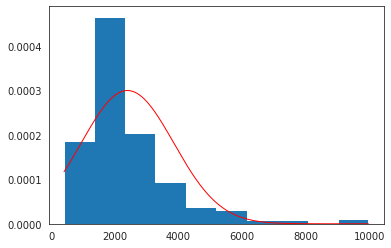

In [17]:
x = np.linspace(CAFOs_Merged['Wisconsin'].dropna().values.min(),CAFOs_Merged['Wisconsin'].dropna().values.max(),CAFOs_Merged['Wisconsin'].dropna().count())
plt.plot(x, stats.truncnorm.pdf(x,
                                (CAFOs_Merged['Wisconsin'].dropna().values.min()-2393.431159)/1457.032638,
                                (CAFOs_Merged['Wisconsin'].dropna().values.max()-2393.431159)/1457.032638,
                                loc =2393.431159,
                                scale =1457.032638),'r-', lw=1, alpha=1, label='gennorm pdf')
# plt.plot(x, stats.gennorm.pdf(x,
#                                 beta1, loc1, scale1	),'r-', lw=1, alpha=1, label='gennorm pdf')
plt.hist(CAFOs_Merged['Wisconsin'].dropna().values, density=True, histtype='stepfilled', alpha=1)
# sns.kdeplot(CAFOs_Merged['Wisconsin'].dropna().values, bw=0.5)

In [18]:
func = lambda x: stats.truncnorm.pdf(x,
                                (CAFOs_Merged['Wisconsin'].dropna().values.min()-2393.431159)/1457.032638,
                                (CAFOs_Merged['Wisconsin'].dropna().values.max()-2393.431159)/1457.032638,
                                loc =2393.431159,
                                scale =1457.032638)

integrate.quad(func, CAFOs_Merged['Wisconsin'].dropna().values.min(), CAFOs_Merged['Wisconsin'].dropna().values.max())

(1.0000000000000004, 1.888688728914604e-14)

In [19]:
func = lambda x: stats.gennorm.pdf(x,
                                beta1, loc1, scale1	)

integrate.quad(func, CAFOs_Merged['Wisconsin'].dropna().values.min(), CAFOs_Merged['Wisconsin'].dropna().values.max())

(0.0, 0.0)

# Looking at the reults above, maybe study two scenarios, one with little mean CAFO size and 1 big mean CAFO size?

### CAFOs clusters:

- $\lt$ 2000
- 2000 - 5000
- $\gt$ 5000

### Scenario 1: Big mean, type Ohio, Michigan, and Wisconsin

In [20]:
param_df_Scenario1 = param_df[['Ohio','Michigan','Wisconsin']]

param_df_Scenario1['Mean'] = np.nan
# param_df_Scenario1.is_copy = False

param_df_Scenario1['Mean']= param_df_Scenario1.mean(axis=1)
param_df_Scenario1.to_csv('Scenario1/param_df_Scenario1.csv')

param_df_Scenario1

/tmp/ipykernel_30102/3294609854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_df_Scenario1['Mean'] = np.nan
/tmp/ipykernel_30102/3294609854.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_df_Scenario1['Mean']= param_df_Scenario1.mean(axis=1)


,Ohio,Michigan,Wisconsin,Mean
Parameters,,,,
mean,2415.245283,2461.527778,2393.431159,2423.401407
std,1588.246879,1333.813099,1457.032638,1459.697539
a,820.000000,420.000000,396.000000,545.333333
b,9800.000000,7601.000000,9979.000000,9126.666667


In [21]:
param_df_Scenario1.loc['mean']['Mean']

2423.4014067389785

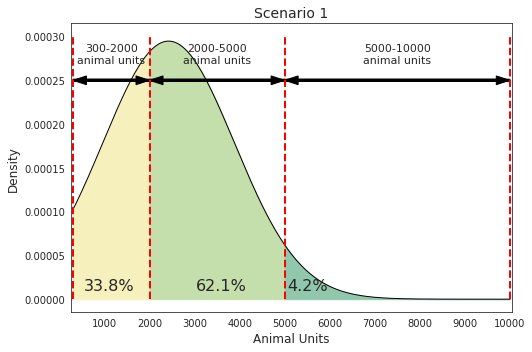

In [22]:
fig, ax =plt.subplots(1,1,figsize=(7.5,5))
# gs = gridspec.GridSpec(3, 4)

# count = 0
# for state in CAFOs_Merged.columns:
    # alpha1, beta1, loc1, scale1 = stats.truncnorm.fit(CAFOs_Merged[state].dropna().values)    
TotalCattleAU_2019 = 1376984.45554917
mean_Scenario1 = param_df_Scenario1.loc['mean']['Mean']
std_Scenario1 = param_df_Scenario1.loc['std']['Mean']
a_Scenario1 = 300
b_Scenario1 = 10000

x = np.linspace(a_Scenario1,b_Scenario1,200)


# if count < 2: #This is for centering the last row of plots
#     ax = plt.subplot(gs[0, 2*count:2*count+2])
# elif count < 4:
#     ax = plt.subplot(gs[1, 2*(count-2):2*(count-2)+2])
# else:
#     ax = plt.subplot(gs[2, 1:3])

# sns.kdeplot(CAFOs_Merged[state].dropna().values, bw_method=0.5, label='KDE distribution', ax=ax)
ax.plot(x, stats.truncnorm.pdf(x,
                            (a_Scenario1-mean_Scenario1)/std_Scenario1,
                            (b_Scenario1-mean_Scenario1)/std_Scenario1,
                            loc =mean_Scenario1,
                            scale =std_Scenario1),'k-', lw=1, alpha=1,
              label='Fit: \na={} \nb={} \nmean={} \nstd={}'.format(a_Scenario1,
                                                              b_Scenario1,
                                                             round(mean_Scenario1,1),round(std_Scenario1,1)))
# ax.hist(CAFOs_Merged[state].dropna().values, density=True, histtype='stepfilled', alpha=1) #bins=CAFOs_Merged[state].dropna().count() NumberOfBins(CAFOs_Merged['Ohio'].dropna())
ax.set_xlim(xmin = a_Scenario1-50, xmax = b_Scenario1+50)
# ax.legend(loc='center right') #names_outflows, loc='upper center', ncol=1, prop={'size': 12}, bbox_to_anchor=(0.35, 0.36)
ax.set_xlabel("Animal Units", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
# ax.set_xticks(np.linspace(CAFOs_Merged[state].min(),CAFOs_Merged[state].max(),5))
# ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_major_locator(MultipleLocator(1000))
# plt.setp(ax.get_xticklabels(), visible=True, rotation=30, ha='right')
# ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.tick_params(axis='both',which='major', width=2, length=2, color='k')
ax.set_title('Scenario 1', fontsize=14)


######################################################################################################################################
# Integrals
######################################################################################################################################

Cluster1_lb_ub = (300,2000)
Cluster2_lb_ub = (2000,5000)
Cluster3_lb_ub = (5000,10000)


func = lambda x: stats.truncnorm.pdf(x,
                                (a_Scenario1-mean_Scenario1)/std_Scenario1,
                                (b_Scenario1-mean_Scenario1)/std_Scenario1,
                                loc =mean_Scenario1,
                                scale =std_Scenario1)

param_df_Scenario1Cluster = pd.DataFrame(['probability','error', 'Animal units'], columns=['Parameters']).set_index('Parameters')


color_dict = {Cluster1_lb_ub:'#F5F0BB',
             Cluster2_lb_ub:'#C4DFAA',
             Cluster3_lb_ub:'#90C8AC',}

pos_dict = {Cluster1_lb_ub:[1100, 0.00001],
             Cluster2_lb_ub:[3600, 0.00001],
             Cluster3_lb_ub:[5500, 0.00001],}

for i in [Cluster1_lb_ub,Cluster2_lb_ub,Cluster3_lb_ub]:
    probability, error = integrate.quad(func, i[0], i[1])
    name = str(i[0])+'-'+str(i[1])
    param_df_Scenario1Cluster[name] = np.nan
    param_df_Scenario1Cluster.loc['probability'][name] = probability
    param_df_Scenario1Cluster.loc['error'][name] = error
    param_df_Scenario1Cluster.loc['Animal units'][name] = param_df_Scenario1Cluster.loc['probability'][name]*TotalCattleAU_2019

    
    ax.fill_between(np.linspace(i[0],i[1],200),func(x = np.linspace(i[0],i[1],200)),
               color= color_dict[i],
                alpha= 0.99)
    
    ax.text(pos_dict[i][0], pos_dict[i][1], str((param_df_Scenario1Cluster.loc['probability'][name]*100).round(1))+'%',
         fontsize=16, horizontalalignment='center')
    
    
    
param_df_Scenario1Cluster.to_csv('Scenario1/param_df_Scenario1Cluster.csv')

ax.vlines(x=[Cluster1_lb_ub[0],Cluster1_lb_ub[1],Cluster2_lb_ub[1],Cluster3_lb_ub[1]],
          ymin=0, ymax=0.0003,
            colors='red', ls='--', lw=2) #

plt.arrow(x=Cluster1_lb_ub[0], y=0.00025,
          dx=Cluster1_lb_ub[1]-Cluster1_lb_ub[0],
          dy=0, head_width=0.00001, head_length=300, width=0.0000025, color='k', length_includes_head=True)
plt.arrow(x=Cluster1_lb_ub[1], y=0.00025,
          dx=-(Cluster1_lb_ub[1]-Cluster1_lb_ub[0]),
          dy=0, head_width=0.00001, head_length=300, width=0.0000025, color='k', length_includes_head=True)

plt.arrow(x=Cluster2_lb_ub[0], y=0.00025,
          dx=Cluster2_lb_ub[1]-Cluster2_lb_ub[0],
          dy=0, head_width=0.00001, head_length=300, width=0.0000025, color='k', length_includes_head=True)
plt.arrow(x=Cluster2_lb_ub[1], y=0.00025,
          dx=-(Cluster2_lb_ub[1]-Cluster2_lb_ub[0]),
          dy=0, head_width=0.00001, head_length=300, width=0.0000025, color='k', length_includes_head=True)

plt.arrow(x=Cluster3_lb_ub[0], y=0.00025,
          dx=Cluster3_lb_ub[1]-Cluster3_lb_ub[0],
          dy=0, head_width=0.00001, head_length=300, width=0.0000025, color='k', length_includes_head=True)
plt.arrow(x=Cluster3_lb_ub[1], y=0.00025,
          dx=-(Cluster3_lb_ub[1]-Cluster3_lb_ub[0]),
          dy=0, head_width=0.00001, head_length=300, width=0.0000025, color='k', length_includes_head=True)


ax.text((Cluster1_lb_ub[1]+Cluster1_lb_ub[0])/2, 0.00027,
        str(Cluster1_lb_ub[0])+'-'+str(Cluster1_lb_ub[1])+'\nanimal units',
         fontsize=11, horizontalalignment='center')

ax.text((Cluster2_lb_ub[1]+Cluster2_lb_ub[0])/2, 0.00027,
        str(Cluster2_lb_ub[0])+'-'+str(Cluster2_lb_ub[1])+'\nanimal units',
         fontsize=11, horizontalalignment='center')

ax.text((Cluster3_lb_ub[1]+Cluster3_lb_ub[0])/2, 0.00027,
        str(Cluster3_lb_ub[0])+'-'+str(Cluster3_lb_ub[1])+'\nanimal units',
         fontsize=11, horizontalalignment='center')

    
fig.tight_layout()
plt.savefig('Scenario1/Scenario1_CAFOs_Size_Distribution.pdf', bbox_inches='tight',)
plt.savefig('Scenario1/Scenario1_CAFOs_Size_Distribution.svg', bbox_inches='tight',)
# param_df.round(decimals=3).to_csv('param_df.csv')


In [23]:
(Cluster2_lb_ub[1]-Cluster2_lb_ub[0])/2

1500.0

In [24]:
def PDF_fit(x, a=a_Scenario1, b=b_Scenario1, mean=mean_Scenario1, std=std_Scenario1):
    return stats.truncnorm.pdf(x,
                            (a-mean)/std,
                            (b-mean)/std,
                            loc =mean,
                            scale =std)

def MonteCarlo_CAFOsSize(TotalAUs=TotalCattleAU_2019,
                         min_x=a_Scenario1,
                         max_x=b_Scenario1,
                         min_y=0,
                         max_y=0,
                         a_truncnorm=a_Scenario1,
                         b_truncnorm=b_Scenario1,
                         mean_truncnorm=mean_Scenario1,
                         std_truncnorm=std_Scenario1):
    
#     Cleaing variables
    # x_MCvector=None
    # y_MCvector=None
    # xCAFO_MCvector=None
    # yCAFO_MCvector=None
    
    x_MCvector=[]
    y_MCvector=[]
    xCAFO_MCvector=[]
    yCAFO_MCvector=[]
    
    while sum(xCAFO_MCvector) < TotalAUs:
        x=random.uniform(min_x, max_x)
        y=random.uniform(min_y,max(PDF_fit(np.linspace(min_x,max_x,200))))
        x_MCvector.append(x)
        y_MCvector.append(y)


        if y <= PDF_fit(x, a=a_truncnorm, b=b_truncnorm, mean=mean_truncnorm, std=std_truncnorm):
            xCAFO_MCvector.append(x)
            yCAFO_MCvector.append(y)  
    # plt.figure()
    # plt.plot(x_MCvector,y_MCvector, 'ko')
    # plt.plot(xCAFO_MCvector,yCAFO_MCvector, 'bo')
    
    return x_MCvector,y_MCvector,xCAFO_MCvector,yCAFO_MCvector



In [25]:
N = 1

xCAFO_MC_total=[]
xCAFO_MC_Cluster1=[]
xCAFO_MC_Cluster2=[]
xCAFO_MC_Cluster3=[]
    
j = 0
while j < N:
    j = j+1
    
    x_MCvector,y_MCvector,xCAFO_MCvector,yCAFO_MCvector = MonteCarlo_CAFOsSize()
    
    xCAFO_MC_total.append(len(xCAFO_MCvector))
    xCAFO_MC_Cluster1.append(len([i for i in xCAFO_MCvector if i <= 2000]))
    xCAFO_MC_Cluster2.append(len([i for i in xCAFO_MCvector if 2000 < i <= 5000]))
    xCAFO_MC_Cluster3.append(len([i for i in xCAFO_MCvector if i > 5000]))
    


In [29]:
Results_Scenario1 = {'Number of CAFOs (300-2000 AU)':[np.mean(xCAFO_MC_Cluster1).round(0)],
                     'Number of CAFOs (2000-5000 AU)':[np.mean(xCAFO_MC_Cluster2).round(0)],
                     'Number of CAFOs (>5000 AU)':[np.mean(xCAFO_MC_Cluster3).round(0)],
                    }
Results_Scenario1_df = pd.DataFrame.from_dict(data=Results_Scenario1,orient='index',columns=['Scenario 1'])
Results_Scenario1_df.to_csv('Scenario1/Results_Scenario1_df.csv')

Results_Scenario1_df

,Scenario 1
Number of CAFOs (300-2000 AU),188.0
Number of CAFOs (2000-5000 AU),320.0
Number of CAFOs (>5000 AU),19.0


In [28]:
CAFOs_Scenario1_df = pd.DataFrame(xCAFO_MCvector, columns=['Number of animals'])
CAFOs_Scenario1_df.to_csv('Scenario1/CAFOs_Scenario1_df.csv')
CAFOs_Scenario1_df

,Number of animals
0,1242.419120
1,4542.073913
2,725.013782
3,3461.014899
4,1012.318738
...,...
522,6052.622364
523,1880.211159
524,842.816232
525,2764.443698


In [30]:
179.0*(2300/2)+322*(3500)+21*5000

1437850.0

In [31]:
# x_MCvector=[]
# y_MCvector=[]
# xCAFO_MCvector=[]
# yCAFO_MCvector=[]
    
# while sum(xCAFO_MCvector) < TotalCattleAU_2019:
#     x=random.uniform(a_Scenario1, b_Scenario1)
#     y=random.uniform(0,max(PDF_fit(np.linspace(a_Scenario1,b_Scenario1,200))))
#     x_MCvector.append(x)
#     y_MCvector.append(y)


#     if y <= PDF_fit(x):
#         xCAFO_MCvector.append(x)
#         yCAFO_MCvector.append(y)  

# plt.figure()
# plt.plot(x_MCvector,y_MCvector, 'ko')
# plt.plot(xCAFO_MCvector,yCAFO_MCvector, 'bo')

# sum(xCAFO_MCvector)

### Scenario 2: Small mean, type Pennsylvania and Indiana

In [32]:
param_df_Scenario2 = param_df[['Pennsylvania','Indiana']]

param_df_Scenario2['Mean'] = np.nan
# param_df_Scenario1.is_copy = False

param_df_Scenario2['Mean']= param_df_Scenario2.mean(axis=1)
param_df_Scenario2.to_csv('Scenario2/param_df_Scenario2.csv')

param_df_Scenario2

/tmp/ipykernel_30102/3971230327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_df_Scenario2['Mean'] = np.nan
/tmp/ipykernel_30102/3971230327.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_df_Scenario2['Mean']= param_df_Scenario2.mean(axis=1)


,Pennsylvania,Indiana,Mean
Parameters,,,
mean,1398.357923,1529.521739,1463.939831
std,1076.216680,1541.598523,1308.907602
a,328.000000,310.000000,319.000000
b,7533.000000,7040.000000,7286.500000


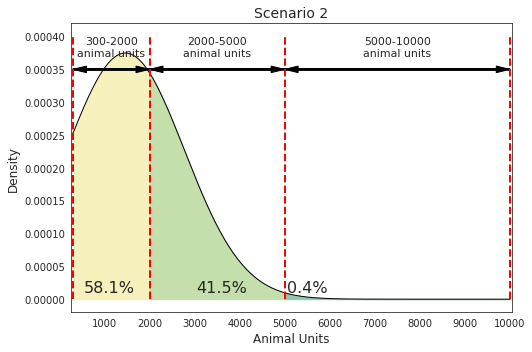

In [33]:
fig, ax =plt.subplots(1,1,figsize=(7.5,5))
# gs = gridspec.GridSpec(3, 4)

# count = 0
# for state in CAFOs_Merged.columns:
    # alpha1, beta1, loc1, scale1 = stats.truncnorm.fit(CAFOs_Merged[state].dropna().values)    
TotalCattleAU_2019 = 1376984.45554917
mean_Scenario2 = param_df_Scenario2.loc['mean']['Mean']
std_Scenario2 = param_df_Scenario2.loc['std']['Mean']
a_Scenario2 = 300
b_Scenario2 = 10000

x = np.linspace(a_Scenario2,b_Scenario2,200)


# if count < 2: #This is for centering the last row of plots
#     ax = plt.subplot(gs[0, 2*count:2*count+2])
# elif count < 4:
#     ax = plt.subplot(gs[1, 2*(count-2):2*(count-2)+2])
# else:
#     ax = plt.subplot(gs[2, 1:3])

# sns.kdeplot(CAFOs_Merged[state].dropna().values, bw_method=0.5, label='KDE distribution', ax=ax)
ax.plot(x, stats.truncnorm.pdf(x,
                            (a_Scenario2-mean_Scenario2)/std_Scenario2,
                            (b_Scenario2-mean_Scenario2)/std_Scenario2,
                            loc =mean_Scenario2,
                            scale =std_Scenario2),'k-', lw=1, alpha=1,
              label='Fit: \na={} \nb={} \nmean={} \nstd={}'.format(a_Scenario2,
                                                              b_Scenario2,
                                                             round(mean_Scenario2,1),round(std_Scenario2,1)))
# ax.hist(CAFOs_Merged[state].dropna().values, density=True, histtype='stepfilled', alpha=1) #bins=CAFOs_Merged[state].dropna().count() NumberOfBins(CAFOs_Merged['Ohio'].dropna())
ax.set_xlim(xmin = a_Scenario2-50, xmax = b_Scenario2+50)
# ax.legend(loc='center right') #names_outflows, loc='upper center', ncol=1, prop={'size': 12}, bbox_to_anchor=(0.35, 0.36)
ax.set_xlabel("Animal Units", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
# ax.set_xticks(np.linspace(CAFOs_Merged[state].min(),CAFOs_Merged[state].max(),5))
# ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_major_locator(MultipleLocator(1000))
# plt.setp(ax.get_xticklabels(), visible=True, rotation=30, ha='right')
# ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.tick_params(axis='both',which='major', width=2, length=2, color='k')
ax.set_title('Scenario 2', fontsize=14)


######################################################################################################################################
# Integrals
######################################################################################################################################

Cluster1_lb_ub = (300,2000)
Cluster2_lb_ub = (2000,5000)
Cluster3_lb_ub = (5000,10000)


func = lambda x: stats.truncnorm.pdf(x,
                                (a_Scenario2-mean_Scenario2)/std_Scenario2,
                                (b_Scenario2-mean_Scenario2)/std_Scenario2,
                                loc =mean_Scenario2,
                                scale =std_Scenario2)

param_df_Scenario2Cluster = pd.DataFrame(['probability','error', 'Animal units'], columns=['Parameters']).set_index('Parameters')


color_dict = {Cluster1_lb_ub:'#F5F0BB',
             Cluster2_lb_ub:'#C4DFAA',
             Cluster3_lb_ub:'#90C8AC',}

pos_dict = {Cluster1_lb_ub:[1100, 0.00001],
             Cluster2_lb_ub:[3600, 0.00001],
             Cluster3_lb_ub:[5500, 0.00001],}

for i in [Cluster1_lb_ub,Cluster2_lb_ub,Cluster3_lb_ub]:
    probability, error = integrate.quad(func, i[0], i[1])
    name = str(i[0])+'-'+str(i[1])
    param_df_Scenario2Cluster[name] = np.nan
    param_df_Scenario2Cluster.loc['probability'][name] = probability
    param_df_Scenario2Cluster.loc['error'][name] = error
    param_df_Scenario2Cluster.loc['Animal units'][name] = param_df_Scenario2Cluster.loc['probability'][name]*TotalCattleAU_2019

    
    ax.fill_between(np.linspace(i[0],i[1],200),func(x = np.linspace(i[0],i[1],200)),
               color= color_dict[i],
                alpha= 0.99)
    
    ax.text(pos_dict[i][0], pos_dict[i][1], str((param_df_Scenario2Cluster.loc['probability'][name]*100).round(1))+'%',
         fontsize=16, horizontalalignment='center')
    
    
    
param_df_Scenario2Cluster.to_csv('Scenario2/param_df_Scenario2Cluster.csv')

ax.vlines(x=[Cluster1_lb_ub[0],Cluster1_lb_ub[1],Cluster2_lb_ub[1],Cluster3_lb_ub[1]],
          ymin=0, ymax=0.0004,
            colors='red', ls='--', lw=2) #

plt.arrow(x=Cluster1_lb_ub[0], y=0.00035,
          dx=Cluster1_lb_ub[1]-Cluster1_lb_ub[0],
          dy=0, head_width=0.00001, head_length=300, width=0.0000025, color='k', length_includes_head=True)
plt.arrow(x=Cluster1_lb_ub[1], y=0.00035,
          dx=-(Cluster1_lb_ub[1]-Cluster1_lb_ub[0]),
          dy=0, head_width=0.00001, head_length=300, width=0.0000025, color='k', length_includes_head=True)

plt.arrow(x=Cluster2_lb_ub[0], y=0.00035,
          dx=Cluster2_lb_ub[1]-Cluster2_lb_ub[0],
          dy=0, head_width=0.00001, head_length=300, width=0.0000025, color='k', length_includes_head=True)
plt.arrow(x=Cluster2_lb_ub[1], y=0.00035,
          dx=-(Cluster2_lb_ub[1]-Cluster2_lb_ub[0]),
          dy=0, head_width=0.00001, head_length=300, width=0.0000025, color='k', length_includes_head=True)

plt.arrow(x=Cluster3_lb_ub[0], y=0.00035,
          dx=Cluster3_lb_ub[1]-Cluster3_lb_ub[0],
          dy=0, head_width=0.00001, head_length=300, width=0.0000025, color='k', length_includes_head=True)
plt.arrow(x=Cluster3_lb_ub[1], y=0.00035,
          dx=-(Cluster3_lb_ub[1]-Cluster3_lb_ub[0]),
          dy=0, head_width=0.00001, head_length=300, width=0.0000025, color='k', length_includes_head=True)


ax.text((Cluster1_lb_ub[1]+Cluster1_lb_ub[0])/2, 0.00037,
        str(Cluster1_lb_ub[0])+'-'+str(Cluster1_lb_ub[1])+'\nanimal units',
         fontsize=11, horizontalalignment='center')

ax.text((Cluster2_lb_ub[1]+Cluster2_lb_ub[0])/2, 0.00037,
        str(Cluster2_lb_ub[0])+'-'+str(Cluster2_lb_ub[1])+'\nanimal units',
         fontsize=11, horizontalalignment='center')

ax.text((Cluster3_lb_ub[1]+Cluster3_lb_ub[0])/2, 0.00037,
        str(Cluster3_lb_ub[0])+'-'+str(Cluster3_lb_ub[1])+'\nanimal units',
         fontsize=11, horizontalalignment='center')
    
fig.tight_layout()
plt.savefig('Scenario2/Scenario2_CAFOs_Size_Distribution.pdf', bbox_inches='tight',)
plt.savefig('Scenario2/Scenario2_CAFOs_Size_Distribution.svg', bbox_inches='tight',)
# param_df.round(decimals=3).to_csv('param_df.csv')


In [34]:
mean_Scenario2

1463.939831103679

In [35]:
N = 1

xCAFO_MC_total=[]
xCAFO_MC_Cluster1=[]
xCAFO_MC_Cluster2=[]
xCAFO_MC_Cluster3=[]
    
j = 0
while j < N:
    j = j+1
    
    x_MCvector,y_MCvector,xCAFO_MCvector,yCAFO_MCvector = MonteCarlo_CAFOsSize(min_x=a_Scenario2,
                                                                              max_x=b_Scenario2,
                                                                              a_truncnorm=a_Scenario1,
                                                                                 b_truncnorm=b_Scenario2,
                                                                                 mean_truncnorm=mean_Scenario2,
                                                                                 std_truncnorm=std_Scenario2)
    
    xCAFO_MC_total.append(len(xCAFO_MCvector))
    xCAFO_MC_Cluster1.append(len([i for i in xCAFO_MCvector if i <= 2000]))
    xCAFO_MC_Cluster2.append(len([i for i in xCAFO_MCvector if 2000 < i <= 5000]))
    xCAFO_MC_Cluster3.append(len([i for i in xCAFO_MCvector if i > 5000]))


In [36]:
Results_Scenario2 = {'Number of CAFOs (300-2000 AU)':[np.mean(xCAFO_MC_Cluster1).round(0)],
                     'Number of CAFOs (2000-5000 AU)':[np.mean(xCAFO_MC_Cluster2).round(0)],
                     'Number of CAFOs (>5000 AU)':[np.mean(xCAFO_MC_Cluster3).round(0)],
                    }
Results_Scenario2_df = pd.DataFrame.from_dict(data=Results_Scenario2,orient='index',columns=['Scenario 2'])
Results_Scenario2_df.to_csv('Scenario2/Results_Scenario2_df.csv')

Results_Scenario2_df



,Scenario 2
Number of CAFOs (300-2000 AU),383.0
Number of CAFOs (2000-5000 AU),313.0
Number of CAFOs (>5000 AU),2.0


In [38]:
CAFOs_Scenario2_df = pd.DataFrame(xCAFO_MCvector, columns=['Number of animals'])
CAFOs_Scenario2_df.to_csv('Scenario2/CAFOs_Scenario2_df.csv')
CAFOs_Scenario2_df

,Number of animals
0,1891.411476
1,4359.696014
2,1303.407175
3,1099.251849
4,3052.516945
...,...
693,1831.233422
694,359.846908
695,1454.301006
696,346.370518


### Collecting results from both scenarios

In [39]:
Results_Scenario1_df = pd.read_csv('Scenario1/Results_Scenario1_df.csv', sep=",", header=0, index_col=0)
Results_Scenario2_df = pd.read_csv('Scenario2/Results_Scenario2_df.csv', sep=",", header=0, index_col=0)

CAFOsSize_Scenarios = pd.concat([Results_Scenario1_df,Results_Scenario2_df], axis=1)
# CAFOsSize_Scenarios['Scenario'] = ['Scenario 1','Scenario 2']
# CAFOsSize_Scenarios = CAFOsSize_Scenarios.set_index('Scenario')

CAFOsSize_Scenarios.loc['mean'] = [param_df_Scenario1.loc['mean']['Mean'],param_df_Scenario2.loc['mean']['Mean']]
CAFOsSize_Scenarios.loc['std'] = [param_df_Scenario1.loc['std']['Mean'],param_df_Scenario2.loc['std']['Mean']]
CAFOsSize_Scenarios.loc['a'] = [Cluster1_lb_ub[0],Cluster3_lb_ub[1]]
CAFOsSize_Scenarios.loc['b'] = [Cluster1_lb_ub[0],Cluster3_lb_ub[1]]

CAFOsSize_Scenarios = CAFOsSize_Scenarios.reindex(["mean", "std", "a","b",
                                                   "Number of CAFOs (300-2000 AU)",
                                                   "Number of CAFOs (2000-5000 AU)",
                                                   "Number of CAFOs (>5000 AU)",])

CAFOsSize_Scenarios = CAFOsSize_Scenarios.round(3)
CAFOsSize_Scenarios.index = CAFOsSize_Scenarios.index.rename('Parameter')

CAFOsSize_Scenarios.to_csv('CAFOsSize_Scenarios.csv')

CAFOsSize_Scenarios

,Scenario 1,Scenario 2
Parameter,,
mean,2423.401,1463.940
std,1459.698,1308.908
a,300.000,10000.000
b,300.000,10000.000
Number of CAFOs (300-2000 AU),188.000,383.000
Number of CAFOs (2000-5000 AU),320.000,313.000
Number of CAFOs (>5000 AU),19.000,2.000


In [134]:
CAFOsSize_Scenarios.index.name()

TypeError: 'NoneType' object is not callable

In [37]:
print(CAFOsSize_Scenarios.to_latex(index=True))  

\begin{tabular}{lrrr}
\toprule
{} &  Cluster1 (300-2000 AU) &  Cluster2 (2000-5000 AU) &  Cluster3 (>5000 AU) \\
Scenario   &                         &                          &                      \\
\midrule
Scenario 1 &                   175.0 &                    324.0 &                 23.0 \\
Scenario 2 &                   386.0 &                    318.0 &                  4.0 \\
\bottomrule
\end{tabular}



# Distribution of Swine CAFOs

In [40]:
waste_data_input = pd.read_csv('AnimalParameters/waste_data_input.csv', sep=",", header=0, index_col=0)
float(waste_data_input.loc['SwineInmature']['AU_equivalence'])

9.09

### Indiana

### Import Indiana dataset

In [41]:
Indiana_df = geopandas.read_file('CAFOs_Indiana/Confined_Feeding_Operations_IDEM_IN.shp')
Indiana_df.crs = {'init' :'epsg:4326'}

/home/emh/Documents/PFlows/venv/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [42]:
Indiana_df

,MASTER_AI_,ALTERNATE_,ALTERNATE1,PARISH_OR_,PARISH_OR1,PHYSICAL_A,PHYSICAL_1,PHYSICAL_2,PHYSICAL_3,SECTION_DE,TOWNSHIP_C,RANGE_CODE,Y_COORD_ST,X_COORD_ST,SUB_PROGRA,FARM_SIZE_,APP_RECEIV,APPROVAL_D,EFFECTIVE_,APPROVAL_N,NPDES_PERM,NPDES_ISSU,NPDES_TYPE,TRANSITION,MMP_APP_RE,MMP_ISSUE_,NOTICE_DUE,NOTICE_REC,AFFIDAVIT_,AFFIDAVIT1,AFFIDAVI_1,NURSERY_PI,FINISHERS,SOWS,BOARS,BEEF_CATTL,BEEF_CALVE,DAIRY_CATT,DAIRY_CALV,VEAL_CALVE,DIARY_HEIF,LAYERS,PULLETS,BROILERS,POULTS,TURKEYS,DUCKS,SHEEP,HORSES,GLOBALID,geometry
0,56763,4754,Swinford Farms Incorporated Herd 3,083,Vermillion,7649 S CR 150 E,None,Hillsdale,47854,5,15N,09W,39.774270,-87.436465,CFO,CAFO,1996-09-16,1996-10-03,1996-10-03,4219,ING804754,2008-09-10,NPDES General Renewal,Yes,2013-10-17,2013-12-09,None,None,None,None,None,3200.0,10664.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{AC613BDB-074B-4BFF-B13F-2212C808C86B},POINT (462621.49142 4402794.13729)
1,61003,4757,Ripberger Farms Incorporated South Farm,070,Rush,7151 E CR 600 N,None,Falmouth,46127,4,14N,11E,39.700607,-85.317126,CFO,CFO,1993-06-30,1993-11-01,1993-11-01,2913,None,None,None,None,2014-09-23,2015-04-08,None,None,None,None,None,600.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{32CBE028-3C7E-49FE-8647-AC0037C7EE16},POINT (644279.29407 4395881.25494)
2,60994,4866,Bart Hicks Hicks Brothers,069,Ripley,3871 W CR 1050 N,None,Osgood,47037,17,09N,11E,39.224578,-85.332103,CFO,CFO,2001-10-04,2002-01-04,2002-01-04,5144,None,None,None,None,2016-06-13,2016-06-21,None,None,None,2003-01-14,Completed,300.0,900.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{BEAD221E-BC96-4727-B281-9B5F99DB2529},POINT (643973.00723 4343023.25020)
3,35691,4869,Lloyd Hochstetler L & M Farm,020,Elkhart,72194 CR 133,None,Syracuse,46567,32,35N,07E,41.447993,-85.740022,CFO,CFO,2006-08-02,2006-09-11,2006-09-11,5656,None,None,None,None,2016-07-20,2016-08-31,None,2006-10-03,None,2007-01-16,Completed,0.0,2280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{1456A5EE-A7CF-4579-9927-1E866EBEF531},POINT (605246.85269 4589255.68547)
4,8114,4870,CJ Shaof Farms Incorporated,003,Bartholomew,15793 E CR 800 N,None,Hope,47246,16,10N,07E,39.320588,-85.750476,CFO,CFO,1994-05-31,1994-06-10,1994-06-10,3247,None,None,None,None,2016-06-24,2016-07-20,None,None,None,None,None,4000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{87AB7E0B-75F2-47E3-9B3C-12A6912EFC5E},POINT (607710.65791 4353097.02392)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1832,120208,7008,Templeton LLC,003,Bartholomew,20530 W CR 700 N,None,Hope,47246,13,10N,07E,39.305498,-85.695044,CFO,CAFO,2018-02-09,2018-05-16,2018-05-16,6757,None,None,None,None,None,None,2023-05-15,2018-10-01,2023-05-15,None,None,6000.0,5000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{36C7CCF3-D467-4342-8D21-FB109771EA85},POINT (612513.28210 4351489.80336)
1833,120252,7009,Schwering Livestock LLC,070,Rush,5374 N SR 3,None,Rushville,46173,5,14N,10E,39.689494,-85.440541,CFO,CAFO,2018-02-21,2018-04-27,2018-04-27,6754,None,None,None,None,None,None,2023-04-26,2018-05-17,2023-04-26,None,None,10000.0,5000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{DF6CB041-2FBE-42D9-9783-4C7215550765},POINT (633719.44031 4394456.48774)
1834,55382,701,Infinity Pork IP2,079,Tippecanoe,County Line Rd & CR 700 E,None,Clarks Hill,47930,33,21N,03W,40.214631,-86.764403,CFO,CFO,1996-06-21,1996-07-12,1996-07-12,4156,None,None,None,None,2010-06-28,2010-07-19,None,None,None,None,None,0.0,0.0,1478.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{9ADB0B4F-302C-474D-AC89-CD777199A69A},POINT (520047.82671 4451605.40712)
1835,108549,6831,Sandy Slope Acres LLC,044,Lagrange,CR 750 N & CR 800 W,None,Shipshewana,46565,14,38N,08E,41.748794,-85.5826

In [43]:
Indiana_df_Swine = Indiana_df[(Indiana_df.NURSERY_PI > 0) | (Indiana_df.FINISHERS > 0) | (Indiana_df.SOWS) | (Indiana_df.BOARS)]
# Indiana_df_Swine_filtered = Indiana_df_Swine.copy()
for i in Indiana_df_Swine.columns:
    if i != 'Y_COORD_ST' and i != 'X_COORD_ST' and i != 'NURSERY_PI' and i != 'FINISHERS' and i != 'SOWS' and i != 'BOARS' and i != 'PHYSICAL_A':
        Indiana_df_Swine = Indiana_df_Swine.drop([i], axis=1) 

Indiana_df_Swine = Indiana_df_Swine.rename(columns={"Y_COORD_ST": "latitude", 
                                                                    "X_COORD_ST": "longitude",
                                                                    "PHYSICAL_A": "Physical Address",})

Indiana_df_Swine['Animal Units'] = ((Indiana_df_Swine.NURSERY_PI+Indiana_df_Swine.FINISHERS)/float(waste_data_input.loc['SwineInmature']['AU_equivalence'])
                                             +(Indiana_df_Swine.SOWS+Indiana_df_Swine.BOARS)/float(waste_data_input.loc['SwineMature']['AU_equivalence']))

Indiana_df_Swine = Indiana_df_Swine[Indiana_df_Swine['Animal Units']>300]
Indiana_df_Swine = Indiana_df_Swine.reset_index()
Indiana_df_Swine.to_csv('Swine/Indiana_df_Swine.csv')
Indiana_df_Swine

,index,Physical Address,latitude,longitude,NURSERY_PI,FINISHERS,SOWS,BOARS,Animal Units
0,0,7649 S CR 150 E,39.774270,-87.436465,3200.0,10664.0,0.0,0.0,1525.192519
1,4,15793 E CR 800 N,39.320588,-85.750476,4000.0,0.0,0.0,0.0,440.044004
2,6,9844 W CR 100 N,39.350075,-85.658551,1000.0,2000.0,7470.0,0.0,3127.785812
3,8,SR 25 & CR 1300 W,41.172946,-86.073616,1020.0,1780.0,0.0,0.0,308.030803
4,12,10564 W CR 200 S,40.134975,-85.176374,0.0,4400.0,0.0,0.0,484.048405
...,...,...,...,...,...,...,...,...,...
819,1827,CR 150 W & CR 600 N,39.423985,-85.518788,5500.0,5500.0,0.0,0.0,1210.121012
820,1829,CR 400 S & CR 850 E,40.382199,-84.817383,0.0,9200.0,0.0,0.0,1012.101210
821,1832,20530 W CR 700 N,39.305498,-85.695044,6000.0,5000.0,0.0,0.0,1210.121012
822,1833,5374 N SR 3,39.689494,-85.440541,10000.0,5000.0,0.0,0.0,1650.165017


### Pennsylvania

In [44]:
Pennsylvania_df = pd.read_csv('CAFOs_Pennsylvania/CAFOs_Pennsylvania.csv', sep=",", header=0, index_col=0)
# Pennsylvania report animal units directly

Pennsylvania_df_Swine = Pennsylvania_df[Pennsylvania_df['ANIMAL_TYPES'].notnull()] #remove nan
Pennsylvania_df_Swine = Pennsylvania_df_Swine[Pennsylvania_df_Swine['ANIMAL_TYPES'].str.contains("Swine")]
Pennsylvania_df_Swine = Pennsylvania_df_Swine.reset_index()
#Penn reports the total animal units, although the rows are duplicated indicating the different tupes of animals
Pennsylvania_df_Swine = Pennsylvania_df_Swine.drop_duplicates(subset='PRIMARY_FACILITY_ID', keep='first')
Pennsylvania_df_Swine = Pennsylvania_df_Swine[Pennsylvania_df_Swine['TOTAL_AEUS'] > 300]
Pennsylvania_df_Swine = Pennsylvania_df_Swine.rename(columns={'TOTAL_AEUS':'Animal Units'})

Pennsylvania_df_Swine = Pennsylvania_df_Swine.reset_index()


Pennsylvania_df_Swine.to_csv('Swine/Pennsylvania_df_Swine.csv')

Pennsylvania_df_Swine

,index,PRIMARY_FACILITY_ID,FACILITY_NAME,PERMIT_NO,CLIENT_ID,CLIENT_NAME,MUNICIPALITY,COUNTY,REGION,PERMIT_TYPE,FEE_CATEGORY,LATEST_PERMIT_ISSUE_DATE,AVAILABLE_LAND,Animal Units,LOCATION_ADDRESS,LOCATION_ADDRESS_CITY_STATE_ZIP,ANIMAL_TYPES
0,0,550894,PERRY MEADOWS CAFO,PA0088064,216104,COUNTRY VIEW FAMILY FARMS LLC,Jackson Twp,Perry,SCRO,Concentrated Animal Feed Operations Indiv NPDE...,CAFO Individual Permit,10/04/2018,1.00,1342.30,2713 FOWLERS HOLLOW RD,"BLAIN, PA 17006",Swine - Wean to finish - 140 lbs (15-265)
1,4,555759,HUSTON HOLLOW FARM CAFO,PA0088242,216104,COUNTRY VIEW FAMILY FARMS LLC,Taylor Twp,Fulton,SCRO,Concentrated Animal Feed Operations Indiv NPDE...,CAFO Individual Permit,06/27/2018,1.00,2984.25,2994 S MADDEN RD,"HUSTONTOWN, PA 17229-9155",Swine - Grow finish - 155 lbs (45-265)
2,8,564215,WIDE AWAKE FARM CAFO,PA0088595,263132,WIDE AWAKE FARMS PARTNERSHIP,Monroe Twp,Bedford,SCRO,Concentrated Animal Feed Operations Indiv NPDE...,CAFO Individual Permit,06/22/2016,112.90,555.62,488 JAY RD,"CLEARVILLE, PA 15535-6201",Swine - Grow finish - 155 lbs (45-265)
3,12,569664,FINE SWINE FARM CAFO,PA0088706,334370,FINE SWINE LLC,West Cocalico Twp,Lancaster,SCRO,Concentrated Animal Feed Operations Indiv NPDE...,CAFO Individual Permit,11/14/2018,1.00,591.80,415 FOREST RD,"DENVER, PA 17517-9482",Swine - Gestating Sow - 400 lbs
4,15,568959,ASPEN PERRY HOG FARM CAFO,PA0088846,158117,HERSHEY AG,Oliver Twp,Perry,SCRO,Concentrated Animal Feed Operations Indiv NPDE...,CAFO Individual Permit,12/01/2017,85.90,1865.10,1027 OAK HALL RD,"NEWPORT, PA 17074",Swine - Nursery Pig - 30 lbs (15-45)
5,17,569084,KEATING FARM CAFO,PA0088927,158980,KEATING JOHN W JR,Southampton Twp,Bedford,SCRO,Concentrated Animal Feed Operations Indiv NPDE...,CAFO Individual Permit,08/29/2019,126.60,612.04,1620 BEANS COVE RD,"CLEARVILLE, PA 15535-8037",Swine - Grow finish - 155 lbs (45-265)
6,18,565301,SCHRACK FARMS PARTNERSHIP CAFO,PA0228401,122703,SCHRACK FARMS PARTNERSHIP,Logan Twp,Clinton,NCRO,"Water Quality Mgmt Part II, Manure Storage Fac...",CAFO Individual Permit,04/26/2019,2092.90,2097.33,860 W VALLEY RD,"LOGANTON, PA 17747-8935",Swine - Grow finish - 155 lbs (45-265)
7,20,691813,JIM KURTZ FARM CAFO,PA0228982,247841,KURTZ JAMES,West Buffalo Twp,Union,NCRO,Concentrated Animal Feed Operations Indiv NPDE...,CAFO Individual Permit,09/10/2018,16.89,735.59,1070 GRAND VALLEY RD,"MIFFLINBURG, PA 17844-7960",Swine - Grow finish - 155 lbs (45-265)
8,21,689442,GNH FARMS LLC CAFO,PA0229091,253889,GREG A HALADAY,Cleveland Twp,Columbia,NCRO,Concentrated Animal Feed Operations Indiv NPDE...,CAFO Individual Permit,05/08/2015,495.50,622.11,224 WHITE CHURCH RD,"ELYSBURG, PA 17824-9161",Swine - Wean to finish - 140 lbs (15-265)
9,23,689723,NEWSWANGER CAFO GARREAU FARM,PA0229105,253920,AMOS NEWSWANGER,Buffalo Twp,Union,NCRO,Concentrated Animal Feed Operations Indiv NPDE...,CAFO Individual Permit,05/23/2013,0.01,571.95,318 BLACK RUN RD,"LEWISBURG, PA 17837-7627",Swine - Grow finish - 155 lbs (45-265)


### Ohio

In [45]:
Ohio_df = pd.read_csv('CAFOs_Ohio/2019.08.06_ODA-DLEP Facilities List.csv', sep=",", header=0, index_col=0)

Ohio_df_Swine = Ohio_df[(Ohio_df['Animal 1 Species'].str.contains('Swine')) | (Ohio_df['Animal 2 Species'].str.contains('Swine'))]

#all swine are considered immature
for index, row in Ohio_df_Swine.iterrows():
    AU1 = 0
    if 'Swine' in Ohio_df_Swine.loc[index, 'Animal 1 Species']:
        AU1 = Ohio_df_Swine.loc[index, 'Animal 1 Count']/float(waste_data_input.loc['SwineInmature']['AU_equivalence'])
    
    AU2 = 0
    if pd.isnull(Ohio_df_Swine.loc[index,'Animal 2 Species'])==False and 'Swine' in Ohio_df_Swine.loc[index, 'Animal 2 Species']:
        AU2 = Ohio_df_Swine.loc[index, 'Animal 2 Count']/float(waste_data_input.loc['SwineInmature']['AU_equivalence'])
    
    Ohio_df_Swine.loc[index, 'Animal Units'] = AU1+AU2

Ohio_df_Swine = Ohio_df_Swine[Ohio_df_Swine['Animal Units']>300]

Ohio_df_Swine = Ohio_df_Swine.reset_index()

Ohio_df_Swine.to_csv('Swine/Ohio_df_Swine.csv')

Ohio_df_Swine

/home/emh/Documents/PFlows/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/emh/Documents/PFlows/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Facility Name,Address,City,County,State,Zip,Township,Watershed,Animal 1 Species,Animal 1 Count,Animal 2 Species,Animal 2 Count,Animal Units
0,Anderson Farms,9000 Greenville Road,Sidney,Shelby,OH,45365,Turtle Creek,05080001 - Upper Great Miami,Swine - over 55 lbs,3840,Beef,80.0,422.442244
1,Arnold Road Farm,7410 Arnold Road,Greenville,Darke,OH,45441,Greenville,05080001 - Upper Great Miami,Swine - over 55 lbs,8000,NaN,NaN,880.088009
2,Bernath Farms 1 and 2,8641 C. Rd. 18,Wauseon,Fulton,OH,43567,Dover,04100006 - Tiffin,Swine - over 55 lbs,5000,NaN,NaN,550.055006
3,Bob Sinn Swine,15250 Rd. 24,Grover Hill,Paulding,OH,45849,Latty,04100007 - Auglaize,Swine - over 55 lbs,4800,NaN,NaN,528.052805
4,Bowersock Pork,03097 State Route 197,Spencerville,Auglaize,OH,45887,Salem,04100004 - St. Marys,Swine - over 55 lbs,4800,Beef,20.0,528.052805
5,Boyer Farms,1974 C.R. 161,Oak Harbor,Ottawa,OH,43449,Harris,04100010 - Cedar-Portage,Swine - over 55 lbs,4800,NaN,NaN,528.052805
6,Bruce Rosswurm Swine Farm,5100 Road 59,Payne,Paulding,OH,45880,Blue Creek,04100007 - Auglaize,Swine - over 55 lbs,4800,NaN,NaN,528.052805
7,Bussey Finishers,4435 Clark Station Road,Greenville,Darke,OH,45331,Liberty,05080001 - Upper Great Miami,Swine - over 55 lbs,4800,NaN,NaN,528.052805
8,"C W Farms, LLC",3347 Mentzer Road,Convoy,Van Wert,Ohio,45832,Tully,04100007 - Auglaize,Swine - over 55 lbs,6500,NaN,NaN,715.071507
9,Canal Farm,4486 Road 197,Cloverdale,Paulding,OH,45827,Washington,04100007 - Auglaize,Swine - over 55 lbs,3582,NaN,NaN,394.059406


### Michigan

In [46]:
Michigan_df = pd.read_csv('CAFOs_Michigan/CAFOs_Michigan_original.csv', sep=",", header=1, index_col=0)

#all swine are considered immature
Michigan_df_Swine = Michigan_df[Michigan_df[' Swine (All wgts.) '].notnull()]
Michigan_df_Swine['Animal Units'] = Michigan_df_Swine[' Swine (All wgts.) ']/float(waste_data_input.loc['SwineInmature']['AU_equivalence'])
Michigan_df_Swine = Michigan_df_Swine[Michigan_df_Swine['Animal Units']>300]

Michigan_df_Swine = Michigan_df_Swine.reset_index()


Michigan_df_Swine.to_csv('Swine/Michigan_df_Swine.csv')

Michigan_df_Swine

/tmp/ipykernel_30102/2660354723.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Michigan_df_Swine['Animal Units'] = Michigan_df_Swine[' Swine (All wgts.) ']/float(waste_data_input.loc['SwineInmature']['AU_equivalence'])


,CAFO Number,Permit Number,Permittee Name,Site Name*,Site Address 1,Site Address 2,Site City,Site State,Site Zip Code,Dairy/Dry Cows/Heifers,Beef Cattle/Veal Calves,Swine (All wgts.),Layers/Broilers/Pullets,Turkeys,Total Animals,"Total CAFO waste,\ngals. (liquid)",Subsidies\n1995-2014,MI Enforcement Actions\nthrough 2016,County,Watershed,Congressional\nDistrict,Additional Names/Previous Owners and Subsidy/MI Enforcement Action Recipients,Animal Units
0,2,MIG010177,Adam Farms,Adam Farms-CAFO,3665 Gettel Road,NaN,Sebewaing,MI,48759.0,NaN,NaN,3000.0,NaN,NaN,3000,9.308000e+05,"$ 382,478",1.0,Huron,SW Lake Huron,10.0,NaN,330.033003
1,3,MIG010217,James and Donna Kober,Alpine Pork LLC - CAFO,8151 Peach Ridge Ave. NW,NaN,Sparta,MI,49345.0,NaN,NaN,4242.0,NaN,NaN,4242,1.455000e+06,NaN,0.0,Kent,SE Lake Michigan,3.0,NaN,466.666667
2,6,MIG010203,Ed Oplinger,ATE Farms LLC-CAFO,1/2 mile East of corner of North Sherman Road ...,2000 feet east of North Wyman Rd. at the end o...,Weidman,MI,48893.0,NaN,NaN,9600.0,NaN,NaN,9600,2.635695e+06,"$ 250,624",1.0,Isabella,Saginaw,4.0,Oplinger Farm and Son,1056.105611
3,9,MIG010030,Baker Farms,Baker Farms-CAFO,64191 N M66,NaN,Sturgis,MI,49091.0,NaN,NaN,3000.0,NaN,NaN,3000,1.375573e+06,"$ 3,814",5.0,St. Joseph,SE Lake Michigan,6.0,NaN,330.033003
4,15,MIG010166,Aaron Bennett,Bennett Farms Livestock-CAFO,8170 South Brucker,NaN,Fremont,MI,49412.0,NaN,NaN,8200.0,NaN,NaN,8200,1.186000e+06,"$ 516,747",2.0,Newaygo,NE Lake Michigan,2.0,"Bennett Farms Livestock, LLC",902.090209
5,22,MIG010075,"Boersen Farms Ag, LLC",Boersen Farms Ag-CAFO,64233 Baseline Rd.,NaN,South Haven,MI,49090.0,NaN,NaN,4900.0,NaN,NaN,4900,1.700000e+06,"$ 3,249,108",0.0,Van Buren,SE Lake Michigan,6.0,"Hinz Farms LLC, Stamp Farms LLC, Stamp Farms",539.053905
6,23,MIG010067,"Boersen Farms, Inc.",Boerson Farms,6241 Ransom St.,NaN,N. Zeeland,MI,49464.0,NaN,NaN,10180.0,NaN,NaN,10180,1.733000e+06,"$ 498,289",0.0,Allegan,SE Lake Michigan,2.0,NaN,1119.911991
7,24,MIG010222,Scot Boyd,Boyd Farms-CAFO,2501 70th Ave,NaN,Evart,MI,49631.0,NaN,NaN,4677.0,NaN,NaN,4677,1.000000e+06,NaN,0.0,Osceola,NE Lake Michigan,4.0,NaN,514.521452
8,28,MIG010037,Buerge Farm,Buerge Farm-CAFO,4862 West Hayes Road,NaN,Middleton,MI,48856.0,NaN,NaN,8640.0,NaN,NaN,8640,4.889700e+06,"$ 129,160",0.0,Gratiot,SE Lake Michigan,4.0,"Boehs Farm, Regal Boehs Farm",950.495050
9,34,MIG010164,Jane and Michael Casassa,Casassa Hog Farm - CAFO,9254 Fergus Road,NaN,Saint Charles,MI,48655.0,NaN,180.0,5400.0,NaN,NaN,5580,2.295960e+06,"$ 685,269",1.0,Saginaw,Saginaw,4.0,"Casassa Farms, Inc.",594.059406


### Wisconsin

The number of swine facilities in Wisconsin is not significant

### Merging all the states

In [47]:
SwineCAFOs_Dict ={'Ohio':Ohio_df_Swine[(Ohio_df_Swine['Animal Units']> 300) & (Ohio_df_Swine['Animal Units']< 10000)]['Animal Units'],
             'Michigan':Michigan_df_Swine[(Michigan_df_Swine['Animal Units']> 300) & (Michigan_df_Swine['Animal Units']< 10000)]['Animal Units'],
             'Pennsylvania':Pennsylvania_df_Swine[(Pennsylvania_df_Swine['Animal Units']> 300) & (Pennsylvania_df_Swine['Animal Units']< 10000)]['Animal Units'],
             'Indiana':Indiana_df_Swine[(Indiana_df_Swine['Animal Units']> 300) & (Indiana_df_Swine['Animal Units']< 10000)]['Animal Units']}

SwineCAFOs_Merged = pd.DataFrame(data = SwineCAFOs_Dict)
SwineCAFOs_Merged.describe().to_csv('Swine/SwineCAFOs_Merged'+'.csv')
SwineCAFOs_Merged

,Ohio,Michigan,Pennsylvania,Indiana
0,422.442244,330.033003,1342.30,1525.192519
1,880.088009,466.666667,2984.25,440.044004
2,550.055006,1056.105611,555.62,3127.785812
3,528.052805,330.033003,591.80,308.030803
4,528.052805,902.090209,1865.10,484.048405
...,...,...,...,...
819,NaN,NaN,NaN,1210.121012
820,NaN,NaN,NaN,1012.101210
821,NaN,NaN,NaN,1210.121012
822,NaN,NaN,NaN,1650.165017


In [48]:
SwineCAFOs_Merged.describe()

,Ohio,Michigan,Pennsylvania,Indiana
count,91.000000,103.000000,212.000000,824.000000
mean,595.572964,674.531919,903.143821,792.444372
std,241.820372,362.429774,638.873896,579.696679
min,305.390539,308.030803,314.030000,301.765120
25%,439.273927,440.044004,578.305000,461.159009
50%,528.052805,539.053905,687.385000,584.526767
75%,719.251925,848.734873,934.250000,968.096810
max,1678.437844,2589.768977,4492.760000,8037.475433


In [49]:
SwineCAFOs_Merged.sum()

Ohio             54197.139714
Michigan         69476.787679
Pennsylvania    191466.490000
Indiana         652974.162248
dtype: float64

In [50]:
def NumberOfBins(data_list): #computing the optimal number of bins using the Freedman-Diaconis rule
    # Computing IQR
    Q1 = data_list.quantile(0.25)
    Q3 = data_list.quantile(0.75)
    IQR = Q3 - Q1

    bins_width = 2*IQR/(data_list.count()**(1/3)) #Freedman-Diaconis rule

    bins_number = int(round((data_list.max()-data_list.min())/bins_width,0))
    return bins_number

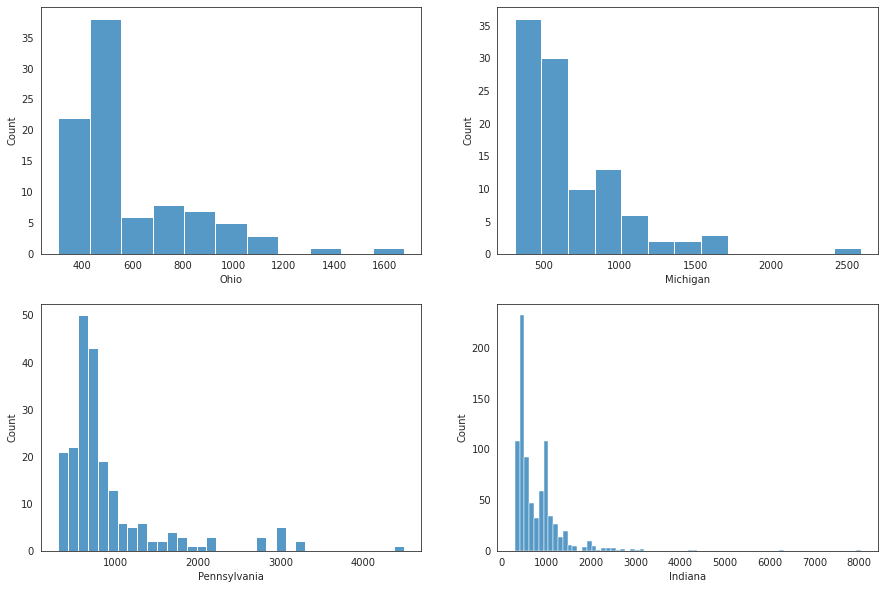

In [51]:
sns.set_style('white')

# fig, ax =plt.subplots(2,3,figsize=(20,10))

# ax_rows = np.arange(0,len(ax)) #This is because it is 2 dimensional array
# ax_columns = np.arange(0,len(ax[0])) #This is because it is 2 dimensional array

# ax_matrix = []#This is because it is 2 dimensional array
# for i in ax_rows:
#     for ii in ax_columns:
#         ax_element = [i,ii]
#         ax_matrix.append(ax_element) 
        
# sns.histplot(CAFOs_Merged[state].dropna(), ax=ax[ax_number[0]][ax_number[1]])


fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2, 2)

count = 0
for state in SwineCAFOs_Merged.columns:
    if count < 2: #This is for centering the last row of plots
        ax = plt.subplot(gs[0, count])
    else:
        ax = plt.subplot(gs[1, count - 2])
              
    sns.histplot(SwineCAFOs_Merged[state].dropna(), ax=ax, bins=NumberOfBins(SwineCAFOs_Merged[state].dropna()) )
    count = count+1

# fig.delaxes(ax[ax_matrix[-1][0],ax_matrix[-1][1]])

# Since the size of CAFOs are limited between 300 and 10,000, we used a truncated normal distribution

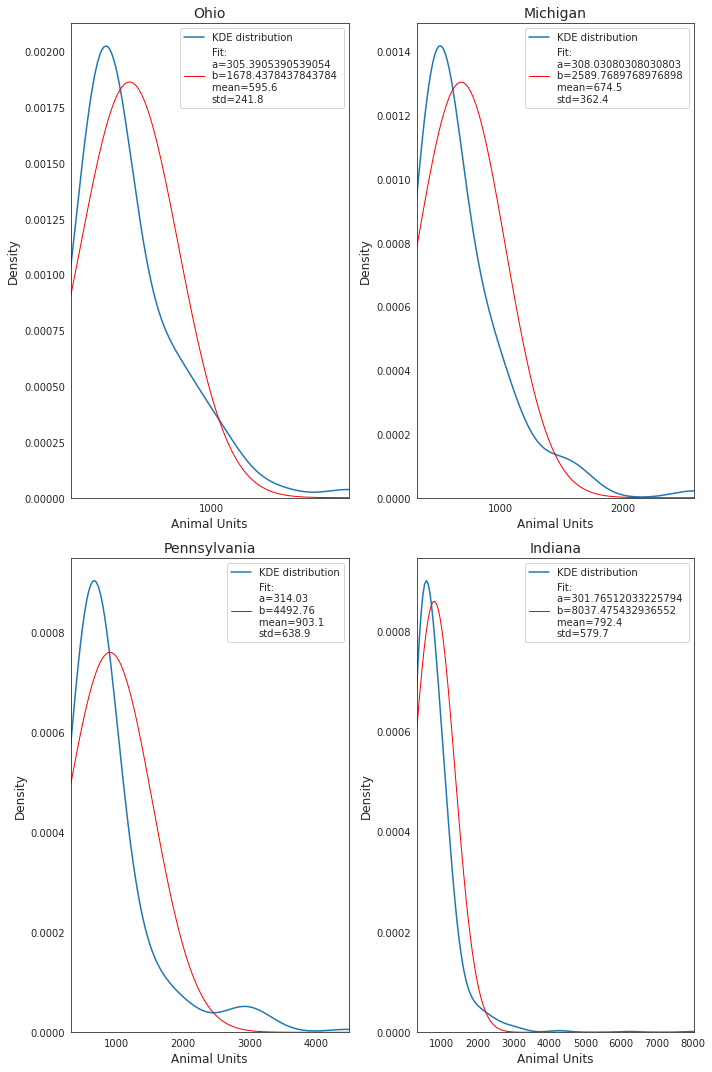

In [52]:
fig = plt.figure(figsize=(10,15))
gs = gridspec.GridSpec(2, 2)

param_df = pd.DataFrame(['mean','std','a','b'], columns=['Parameters']).set_index('Parameters')

count = 0
for state in SwineCAFOs_Merged.columns:
    alpha1, beta1, loc1, scale1 = stats.truncnorm.fit(SwineCAFOs_Merged[state].dropna().values)
    x = np.linspace(SwineCAFOs_Merged[state].dropna().values.min(),SwineCAFOs_Merged[state].dropna().values.max(),SwineCAFOs_Merged[state].dropna().count())
    
    mean = SwineCAFOs_Merged.describe().loc['mean'][state]
    std = SwineCAFOs_Merged.describe().loc['std'][state]
    
    if count < 2: #This is for centering the last row of plots
        ax = plt.subplot(gs[0, count])
    # elif count < 4:
    #     ax = plt.subplot(gs[1, 2*(count-2):2*(count-2)+2])
    else:
        ax = plt.subplot(gs[1, count-2])
              
    sns.kdeplot(SwineCAFOs_Merged[state].dropna().values, bw_method=0.5, label='KDE distribution', ax=ax)
    ax.plot(x, stats.truncnorm.pdf(x,
                                (SwineCAFOs_Merged[state].dropna().values.min()-mean)/std,
                                (SwineCAFOs_Merged[state].dropna().values.max()-mean)/std,
                                loc =mean,
                                scale =std),'r-', lw=1, alpha=1,
                  label='Fit: \na={} \nb={} \nmean={} \nstd={}'.format(SwineCAFOs_Merged[state].dropna().values.min(),
                                                                  SwineCAFOs_Merged[state].dropna().values.max(),
                                                                 round(mean,1),round(std,1)))
    # ax.hist(CAFOs_Merged[state].dropna().values, density=True, histtype='stepfilled', alpha=1) #bins=CAFOs_Merged[state].dropna().count() NumberOfBins(CAFOs_Merged['Ohio'].dropna())
    ax.set_xlim(xmin = SwineCAFOs_Merged[state].min(), xmax = SwineCAFOs_Merged[state].max())
    ax.legend() #names_outflows, loc='upper center', ncol=1, prop={'size': 12}, bbox_to_anchor=(0.35, 0.36)
    ax.set_xlabel("Animal Units", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    # ax.set_xticks(np.linspace(CAFOs_Merged[state].min(),CAFOs_Merged[state].max(),5))
    # ax.tick_params(axis='both', which='major', labelsize=10)
    ax.xaxis.set_major_locator(MultipleLocator(1000))
    # plt.setp(ax.get_xticklabels(), visible=True, rotation=30, ha='right')
    # ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.tick_params(axis='both',which='major', width=2, length=2, color='k')
    ax.set_title(state, fontsize=14)
    
    param_df[state] = np.nan
    param_df.loc['mean'][state] = mean
    param_df.loc['std'][state] = std
    param_df.loc['a'][state] = SwineCAFOs_Merged[state].dropna().values.min().round(decimals=0)
    param_df.loc['b'][state] = SwineCAFOs_Merged[state].dropna().values.max().round(decimals=0)
    
    count = count+1
    
fig.tight_layout()
plt.savefig('Swine/Swine_CAFOs_Size_Distribution.pdf', bbox_inches='tight',)
plt.savefig('Swine/Swine_CAFOs_Size_Distribution.svg', bbox_inches='tight',)
param_df.round(decimals=3).to_csv('param_df.csv')


### CAFOs clusters:

- $\lt$ 2000
- 2000 - 5000
- $\gt$ 5000

In [53]:
param_df_Scenario1 = param_df.copy()

param_df_Scenario1['Mean'] = np.nan
# param_df_Scenario1.is_copy = False

param_df_Scenario1['Mean']= param_df_Scenario1.mean(axis=1)
param_df_Scenario1.to_csv('Swine/param_df_Scenario1.csv')

param_df_Scenario1

,Ohio,Michigan,Pennsylvania,Indiana,Mean
Parameters,,,,,
mean,595.572964,674.531919,903.143821,792.444372,741.423269
std,241.820372,362.429774,638.873896,579.696679,455.705180
a,305.000000,308.000000,314.000000,302.000000,307.250000
b,1678.000000,2590.000000,4493.000000,8037.000000,4199.500000


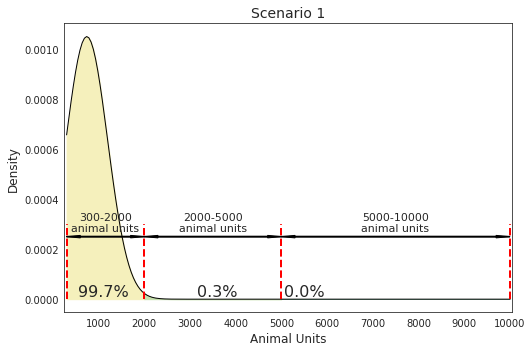

In [54]:
fig, ax =plt.subplots(1,1,figsize=(7.5,5))
# gs = gridspec.GridSpec(3, 4)

# count = 0
# for state in CAFOs_Merged.columns:
    # alpha1, beta1, loc1, scale1 = stats.truncnorm.fit(CAFOs_Merged[state].dropna().values)    
TotalSwineAU_2019 = 506767.504480785
mean_Scenario1 = param_df_Scenario1.loc['mean']['Mean']
std_Scenario1 = param_df_Scenario1.loc['std']['Mean']
a_Scenario1 = 300
b_Scenario1 = 10000

x = np.linspace(a_Scenario1,b_Scenario1,200)


# if count < 2: #This is for centering the last row of plots
#     ax = plt.subplot(gs[0, 2*count:2*count+2])
# elif count < 4:
#     ax = plt.subplot(gs[1, 2*(count-2):2*(count-2)+2])
# else:
#     ax = plt.subplot(gs[2, 1:3])

# sns.kdeplot(CAFOs_Merged[state].dropna().values, bw_method=0.5, label='KDE distribution', ax=ax)
ax.plot(x, stats.truncnorm.pdf(x,
                            (a_Scenario1-mean_Scenario1)/std_Scenario1,
                            (b_Scenario1-mean_Scenario1)/std_Scenario1,
                            loc =mean_Scenario1,
                            scale =std_Scenario1),'k-', lw=1, alpha=1,
              label='Fit: \na={} \nb={} \nmean={} \nstd={}'.format(a_Scenario1,
                                                              b_Scenario1,
                                                             round(mean_Scenario1,1),round(std_Scenario1,1)))
# ax.hist(CAFOs_Merged[state].dropna().values, density=True, histtype='stepfilled', alpha=1) #bins=CAFOs_Merged[state].dropna().count() NumberOfBins(CAFOs_Merged['Ohio'].dropna())
ax.set_xlim(xmin = a_Scenario1-50, xmax = b_Scenario1+50)
# ax.legend(loc='center right') #names_outflows, loc='upper center', ncol=1, prop={'size': 12}, bbox_to_anchor=(0.35, 0.36)
ax.set_xlabel("Animal Units", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
# ax.set_xticks(np.linspace(CAFOs_Merged[state].min(),CAFOs_Merged[state].max(),5))
# ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_major_locator(MultipleLocator(1000))
# plt.setp(ax.get_xticklabels(), visible=True, rotation=30, ha='right')
# ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.tick_params(axis='both',which='major', width=2, length=2, color='k')
ax.set_title('Scenario 1', fontsize=14)


######################################################################################################################################
# Integrals
######################################################################################################################################

Cluster1_lb_ub = (300,2000)
Cluster2_lb_ub = (2000,5000)
Cluster3_lb_ub = (5000,10000)


func = lambda x: stats.truncnorm.pdf(x,
                                (a_Scenario1-mean_Scenario1)/std_Scenario1,
                                (b_Scenario1-mean_Scenario1)/std_Scenario1,
                                loc =mean_Scenario1,
                                scale =std_Scenario1)

param_df_Scenario1Cluster = pd.DataFrame(['probability','error', 'Animal units'], columns=['Parameters']).set_index('Parameters')


color_dict = {Cluster1_lb_ub:'#F5F0BB',
             Cluster2_lb_ub:'#C4DFAA',
             Cluster3_lb_ub:'#90C8AC',}

pos_dict = {Cluster1_lb_ub:[1100, 0.00001],
             Cluster2_lb_ub:[3600, 0.00001],
             Cluster3_lb_ub:[5500, 0.00001],}

for i in [Cluster1_lb_ub,Cluster2_lb_ub,Cluster3_lb_ub]:
    probability, error = integrate.quad(func, i[0], i[1])
    name = str(i[0])+'-'+str(i[1])
    param_df_Scenario1Cluster[name] = np.nan
    param_df_Scenario1Cluster.loc['probability'][name] = probability
    param_df_Scenario1Cluster.loc['error'][name] = error
    param_df_Scenario1Cluster.loc['Animal units'][name] = param_df_Scenario1Cluster.loc['probability'][name]*TotalSwineAU_2019

    
    ax.fill_between(np.linspace(i[0],i[1],200),func(x = np.linspace(i[0],i[1],200)),
               color= color_dict[i],
                alpha= 0.99)
    
    ax.text(pos_dict[i][0], pos_dict[i][1], str((param_df_Scenario1Cluster.loc['probability'][name]*100).round(1))+'%',
         fontsize=16, horizontalalignment='center')
    
    
    
param_df_Scenario1Cluster.to_csv('Scenario1/param_df_Scenario1Cluster.csv')

ax.vlines(x=[Cluster1_lb_ub[0],Cluster1_lb_ub[1],Cluster2_lb_ub[1],Cluster3_lb_ub[1]],
          ymin=0, ymax=0.0003,
            colors='red', ls='--', lw=2) #

plt.arrow(x=Cluster1_lb_ub[0], y=0.00025,
          dx=Cluster1_lb_ub[1]-Cluster1_lb_ub[0],
          dy=0, head_width=0.00001, head_length=300, width=0.0000025, color='k', length_includes_head=True)
plt.arrow(x=Cluster1_lb_ub[1], y=0.00025,
          dx=-(Cluster1_lb_ub[1]-Cluster1_lb_ub[0]),
          dy=0, head_width=0.00001, head_length=300, width=0.0000025, color='k', length_includes_head=True)

plt.arrow(x=Cluster2_lb_ub[0], y=0.00025,
          dx=Cluster2_lb_ub[1]-Cluster2_lb_ub[0],
          dy=0, head_width=0.00001, head_length=300, width=0.0000025, color='k', length_includes_head=True)
plt.arrow(x=Cluster2_lb_ub[1], y=0.00025,
          dx=-(Cluster2_lb_ub[1]-Cluster2_lb_ub[0]),
          dy=0, head_width=0.00001, head_length=300, width=0.0000025, color='k', length_includes_head=True)

plt.arrow(x=Cluster3_lb_ub[0], y=0.00025,
          dx=Cluster3_lb_ub[1]-Cluster3_lb_ub[0],
          dy=0, head_width=0.00001, head_length=300, width=0.0000025, color='k', length_includes_head=True)
plt.arrow(x=Cluster3_lb_ub[1], y=0.00025,
          dx=-(Cluster3_lb_ub[1]-Cluster3_lb_ub[0]),
          dy=0, head_width=0.00001, head_length=300, width=0.0000025, color='k', length_includes_head=True)


ax.text((Cluster1_lb_ub[1]+Cluster1_lb_ub[0])/2, 0.00027,
        str(Cluster1_lb_ub[0])+'-'+str(Cluster1_lb_ub[1])+'\nanimal units',
         fontsize=11, horizontalalignment='center')

ax.text((Cluster2_lb_ub[1]+Cluster2_lb_ub[0])/2, 0.00027,
        str(Cluster2_lb_ub[0])+'-'+str(Cluster2_lb_ub[1])+'\nanimal units',
         fontsize=11, horizontalalignment='center')

ax.text((Cluster3_lb_ub[1]+Cluster3_lb_ub[0])/2, 0.00027,
        str(Cluster3_lb_ub[0])+'-'+str(Cluster3_lb_ub[1])+'\nanimal units',
         fontsize=11, horizontalalignment='center')

    
fig.tight_layout()
plt.savefig('Swine/Scenario1_SwineCAFOs_Size_Distribution.pdf', bbox_inches='tight',)
plt.savefig('Swine/Scenario1_SwineCAFOs_Size_Distribution.svg', bbox_inches='tight',)
# param_df.round(decimals=3).to_csv('param_df.csv')


In [55]:
def PDF_fit(x, a=a_Scenario1, b=b_Scenario1, mean=mean_Scenario1, std=std_Scenario1):
    return stats.truncnorm.pdf(x,
                            (a-mean)/std,
                            (b-mean)/std,
                            loc =mean,
                            scale =std)

def MonteCarlo_CAFOsSize(TotalAUs=TotalSwineAU_2019,
                         min_x=a_Scenario1,
                         max_x=b_Scenario1,
                         min_y=0,
                         max_y=0,
                         a_truncnorm=a_Scenario1,
                         b_truncnorm=b_Scenario1,
                         mean_truncnorm=mean_Scenario1,
                         std_truncnorm=std_Scenario1):
    
#     Cleaing variables
    # x_MCvector=None
    # y_MCvector=None
    # xCAFO_MCvector=None
    # yCAFO_MCvector=None
    
    x_MCvector=[]
    y_MCvector=[]
    xCAFO_MCvector=[]
    yCAFO_MCvector=[]
    
    while sum(xCAFO_MCvector) < TotalAUs:
        x=random.uniform(min_x, max_x)
        y=random.uniform(min_y,max(PDF_fit(np.linspace(min_x,max_x,200))))
        x_MCvector.append(x)
        y_MCvector.append(y)


        if y <= PDF_fit(x, a=a_truncnorm, b=b_truncnorm, mean=mean_truncnorm, std=std_truncnorm):
            xCAFO_MCvector.append(x)
            yCAFO_MCvector.append(y)  
    # plt.figure()
    # plt.plot(x_MCvector,y_MCvector, 'ko')
    # plt.plot(xCAFO_MCvector,yCAFO_MCvector, 'bo')
    
    return x_MCvector,y_MCvector,xCAFO_MCvector,yCAFO_MCvector



In [56]:
N = 1

xCAFO_MC_total=[]
xCAFO_MC_Cluster1=[]
xCAFO_MC_Cluster2=[]
xCAFO_MC_Cluster3=[]
    
j = 0
while j < N:
    j = j+1
    
    x_MCvector,y_MCvector,xCAFO_MCvector,yCAFO_MCvector = MonteCarlo_CAFOsSize()
    
    xCAFO_MC_total.append(len(xCAFO_MCvector))
    xCAFO_MC_Cluster1.append(len([i for i in xCAFO_MCvector if i <= 2000]))
    xCAFO_MC_Cluster2.append(len([i for i in xCAFO_MCvector if 2000 < i <= 5000]))
    xCAFO_MC_Cluster3.append(len([i for i in xCAFO_MCvector if i > 5000]))

In [57]:
Results_Scenario1 = {'Number of CAFOs (300-2000 AU)':[np.mean(xCAFO_MC_Cluster1).round(0)],
                     'Number of CAFOs (2000-5000 AU)':[np.mean(xCAFO_MC_Cluster2).round(0)],
                     'Number of CAFOs (>5000 AU)':[np.mean(xCAFO_MC_Cluster3).round(0)],
                    }
Results_Scenario1_df = pd.DataFrame.from_dict(data=Results_Scenario1,orient='index',columns=['Scenario 1'])
Results_Scenario1_df.to_csv('Swine/Results_Scenario1_Swine_df.csv')

Results_Scenario1_df

,Scenario 1
Number of CAFOs (300-2000 AU),582.0
Number of CAFOs (2000-5000 AU),4.0
Number of CAFOs (>5000 AU),0.0


In [58]:
CAFOs_Scenario1_df = pd.DataFrame(xCAFO_MCvector, columns=['Number of animals'])
CAFOs_Scenario1_df.to_csv('Swine/CAFOs_Scenario1_df.csv')
CAFOs_Scenario1_df

,Number of animals
0,463.685456
1,1030.150829
2,633.662642
3,1052.466189
4,681.793512
...,...
581,629.966461
582,499.007334
583,680.540557
584,1199.778944
